## Import modules

In [2]:
import numpy as np
import os

# to read data
import pickle

# to plot the data
import matplotlib.pyplot as plt

# for neural network
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
from google.colab import drive
drive.mount('/content/drive')

os.chdir("/content/drive/MyDrive/project")
from common_modules import data_f, network_f, patches_f, clusters_f

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# to relead notebook after editing
import importlib
importlib.reload(patches_f)

<module 'common_modules.patches_f' from '/content/drive/MyDrive/project/common_modules/patches_f.py'>

## get and read data

In [6]:
data_f.download_file(url = 'https://drive.google.com/u/0/uc?id=1CdYxeX8g9wxzSnz6R51ELmJJuuZ3xlqa&export=download',
                          saveAs = 'anomaly_dataset.pickle')

infile = open('anomaly_dataset.pickle','rb')
data = pickle.load(infile)
infile.close()

features = 3
train_data = [ [ [input[:,i] for i in range(features) ], label ] for input,label in zip(data[0],data[1]) ]
test_data = [ [ [ input[:,i] for i in range(features) ], label ] for input,label in zip(data[2],data[3]) ]

file downloaded


In [7]:
classes = ["normal","anomaly"]
sample_len = 50
print('number of classes :',len(classes))

print('\ntrain data contains',len(train_data),'samples')
print('test data contains',len(test_data),'samples')

print('\neach sample has 3 channels : x,y and force')
print('length of each channel is', sample_len)

number of classes : 2

train data contains 50000 samples
test data contains 10000 samples

each sample has 3 channels : x,y and force
length of each channel is 50


## patches

In [ ]:
kwargs = {'window_size':10, 'stride':5, 'resizeTo':100, 'medianFilter':False, 'gaussianFilter':True, 'normalize':(0,1)}

kwargs['data'] = train_data
train_inputs, train_labels = patches_f.dataToPatches(**kwargs)
kwargs['data'] = test_data
test_inputs,  test_labels  = patches_f.dataToPatches(**kwargs)

In [ ]:
train_inputs = np.array(train_inputs)
test_inputs = np.array(test_inputs)

train_labels = np.array(train_labels, dtype=int)
test_labels = np.array(test_labels, dtype=int)

In [ ]:
train_loader, val_loader, test_loader = data_f.createLoaders(train_inputs, train_labels,
                                                                  test_inputs, test_labels,
                                                                  batch_size=32)

## neural network

### define network

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 4 input channels, 6 output channels, row convolution kernel of size 3
        self.conv1 = nn.Conv1d(4, 6, 3)
        self.conv2 = nn.Conv1d(6, 16, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(368, 120) 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 20)

    def forward(self, x):
        # output given by : math.floor((inp-(k-1)-1)/s+1)
        x = F.max_pool1d(F.relu(self.conv1(x)), 2)
        x = F.max_pool1d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

### create network

In [ ]:
net = Net().to(device)

#Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### train network

epoch: 20, train loss: 0.450, val loss: 0.451
epoch: 40, train loss: 0.433, val loss: 0.435
epoch: 60, train loss: 0.428, val loss: 0.433
epoch: 80, train loss: 0.426, val loss: 0.432
epoch: 100, train loss: 0.423, val loss: 0.429
epoch: 120, train loss: 0.420, val loss: 0.429
epoch: 140, train loss: 0.417, val loss: 0.429
epoch: 160, train loss: 0.413, val loss: 0.428
epoch: 180, train loss: 0.409, val loss: 0.430
epoch: 200, train loss: 0.404, val loss: 0.436

Finished Training


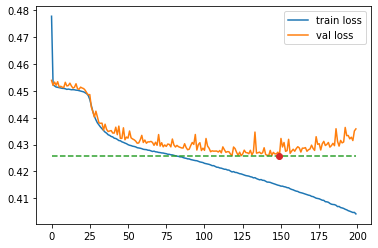

In [ ]:
best_params = network_f.trainNet(net,criterion,optimizer, 
                                  train_loader,val_loader,
                                  epochs=50)

In [ ]:
net.load_state_dict(best_params)

<All keys matched successfully>

### evaluate network

In [ ]:
print("evaluation results on train data")
network_f.evaluate(net,train_loader,classes)
print("evaluation results on test data")
network_f.evaluate(net,test_loader,classes)

evaluation results on train data



              precision    recall  f1-score   support

      normal     0.8478    0.9989    0.9172    281165
     anamoly     0.9498    0.1052    0.1894     56335

    accuracy                         0.8497    337500
   macro avg     0.8988    0.5520    0.5533    337500
weighted avg     0.8649    0.8497    0.7957    337500

evaluation results on test data



              precision    recall  f1-score   support

      normal     0.8434    0.9973    0.9139     74736
     anamoly     0.8775    0.0934    0.1689     15264

    accuracy                         0.8440     90000
   macro avg     0.8605    0.5454    0.5414     90000
weighted avg     0.8492    0.8440    0.7876     90000

